# FISH - Data interpretation - A Python interactive notebook to interpret FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.

```

## Importing libraries

In [1]:
import sys
import matplotlib.pyplot as plt 
from  matplotlib.ticker import FuncFormatter
import numpy as np 
import pandas as pd
import pathlib
import warnings
import glob
import seaborn as sns
import zipfile
import shutil
import scipy.stats as stats
import os
warnings.filterwarnings("ignore")

## Defining paths

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa
# Local folder path
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')
local_folder_path
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'

# creating a folder to store all plots
destination_folder = pathlib.Path().absolute().joinpath('results', 'data_Huy_combinations_final_2')
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder) 

In [3]:
psf_z=350                # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=160               # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
voxel_size_z=500         # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=160        # Microscope conversion px to nanometers in the xy axis.
scale = np.array ([ voxel_size_z/psf_z, voxel_size_yx/psf_yx, voxel_size_yx/psf_yx ])

list_timepoints = [0,18,300]
list_thresholds_intensity =[400,450,500,550]
list_thresholds_distance=[1,2,3]

In [4]:
def extract_spot_classification_from_df(df,show_plots = False,time_point=0,threshold_intensity_0=0,threshold_intensity_1=0,threshold_distance=0):
    number_cells = df['cell_id'].nunique()
    array_spot_type_per_cell = np.zeros((number_cells, 12)).astype(int) # this array will store the spots separated  as types: spot_0_only, spot_1_only, or spot_0_1
    for cell_id in range(number_cells):
        image_id = df[df["cell_id"] == cell_id]['image_id'].values[0]
        # retrieving the coordinates for spots type 0 and 1 for each cell 
        array_spots_0 = np.asarray( df[['z','y','x']][(df["cell_id"] == cell_id) & (df["spot_type"] == 0)] ) # coordinates for spot_type_0 with shape [num_spots_type_0, 3]
        array_spots_1 = np.asarray( df[['z','y','x']][(df["cell_id"] == cell_id) & (df["spot_type"] == 1)] ) # coordinates for spot_type_1 with shape [num_spots_type_1, 3]
        total_spots0 = array_spots_0.shape[0]
        total_spots1 = array_spots_1.shape[0]
        # Concatenating arrays from spots 0 and 1
        array_all_spots = np.concatenate((array_spots_0,array_spots_1), axis=0) 
        # Calculating a distance matrix. 
        distance_matrix = np.zeros( (array_all_spots.shape[0], array_all_spots.shape[0])) #  the distance matrix is an square matrix resulting from the concatenation of both spot  types.
        for i in range(len(array_all_spots)):
            for j in range(len(array_all_spots)):
                if j<i:
                    distance_matrix[i,j] = np.linalg.norm( ( array_all_spots[i,:]-array_all_spots[j,:] ) * scale )
        # masking the distance matrix. Ones indicate the distance is less or equal than threshold_distance
        mask_distance_matrix = (distance_matrix <= threshold_distance) 
        # Selecting the right-lower quadrant as a subsection of the distance matrix that compares one spot type versus the other. 
        subsection_mask_distance_matrix = mask_distance_matrix[total_spots0:, 0:total_spots0].copy()
        if show_plots == True:
            plt.imshow(mask_distance_matrix, cmap='Greys_r')
            plt.imshow(subsection_mask_distance_matrix,cmap='Greys_r')
        # Calculating each type of spots in cell
        #is_spot_only_type_0 = np.all(~subsection_mask_distance_matrix, axis =1 ) # Testing if all the columns are ones of inv(subsection_mask_distance_matrix). Representing spot type 0.
        #is_spot_only_type_1 = np.all(~subsection_mask_distance_matrix, axis =0 ) #  Testing if all the rows are ones of inv(subsection_mask_distance_matrix). Representing spot type 1.
        inv_subsection_mask_distance_matrix = ~subsection_mask_distance_matrix
        # Calculating each type of spots in cell
        is_spot_only_type_0 = np.all(inv_subsection_mask_distance_matrix, axis =0 ) # Testing if all the columns are ones of inv(subsection_mask_distance_matrix). Representing spot type 0. Notice that np.all(arr, axis=0) does the calculation along the columns.
        is_spot_only_type_1 = np.all(inv_subsection_mask_distance_matrix, axis =1 ) #  Testing if all the rows are ones of inv(subsection_mask_distance_matrix). Representing spot type 1. Notice that np.all(arr, axis=1) does the calculation along the rows.    
                
        num_type_0_only = np.sum(is_spot_only_type_0) 
        num_type_1_only =np.sum(is_spot_only_type_1) 
        num_type_0_1 = (total_spots0 - num_type_0_only) + (total_spots1 - num_type_1_only) # Number of spots in both channels
        array_spot_type_per_cell[cell_id,:] = np.array([time_point, threshold_intensity_0,threshold_intensity_1,threshold_distance, 
                                                        image_id, cell_id, num_type_0_only, num_type_1_only, num_type_0_1, 
                                                        num_type_0_only+num_type_0_1, 
                                                        num_type_1_only+num_type_0_1, 
                                                        num_type_0_only+num_type_1_only+num_type_0_1]).astype(int)
        list_labels = ['time','ts_intensity_0','ts_intensity_1','ts_distance','image_id','cell_id','num_0_only','num_1_only','num_0_1','num_0', 'num_1','total']
        # creating a dataframe
        df_spots_classification = pd.DataFrame(data=array_spot_type_per_cell, columns=list_labels)
    return df_spots_classification  


## List of folders to process

In [5]:
def Huy_data(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim',
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM' )
    list_labels = [ 'woSTM','18minTPL_5uM','5hTPL_5uM']
    plot_title_suffix= "MS2_CY5"
    mandatory_substring = mandatory_substring      #'nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

----

# Running the codes

----

In [6]:
substring_to_iterate = 'nuc_71__cyto_0__psfz_350__psfyx_160__ts_'

## Connecting to NAS and extracting data

In [7]:
list_df_paths=[]
list_df_names=[]

list_df_paths_complete=[]
list_df_names_complete=[]
list_df_complete=[]

counter_dataframes =0
ts_distance=2

for k, int_0 in enumerate(list_thresholds_intensity):
    for j, int_1 in enumerate(list_thresholds_intensity):
        mandatory_substring = substring_to_iterate + str(int_0) +'_' + str(int_1)
        list_dirs, list_labels, plot_title_suffix, mandatory_substring = Huy_data(mandatory_substring=mandatory_substring)
        list_local_files = fa.Utilities.read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name, mandatory_substring, local_folder_path)
        list_local_folders = fa.Utilities.unzip_local_folders(list_local_files,local_folder_path)
        list_dataframes = fa.Utilities.extracting_data_for_each_df_in_directory(  list_local_folders=list_local_folders,current_dir=current_dir,minimal_TS_size=2)[6]
        # Iterating for each time point (experimental condition)
        for i,tp in enumerate (list_timepoints):
            df_spots_classification = extract_spot_classification_from_df(df=list_dataframes[i],show_plots = False, time_point=tp, threshold_intensity_0 = int_0,threshold_intensity_1= int_1,threshold_distance=ts_distance )
            df_name = plot_title_suffix+'_time_'+str(tp)+ '_int_'+str(int_0)+ '_'+str(int_1)+ '_dist_'+str(ts_distance)
            df_path=pathlib.Path().absolute().joinpath(destination_folder,df_name +'.csv')
            df_spots_classification.to_csv(df_path, index = False)
            df_spots_classification = ""
            list_df_paths.append(df_path)
            list_df_names.append(df_name)
            counter_dataframes+=1
            # saving the  original dataframe  back to the same folder
            df_name_complete = 'complete__'+plot_title_suffix+'_time_'+str(tp)+ '_int_'+str(int_0)+ '_'+str(int_1)+'.csv'
            df_path_complete = pathlib.Path().absolute().joinpath(destination_folder,df_name_complete)
            list_dataframes[i].to_csv(df_path_complete)
            list_df_paths_complete.append(df_path_complete)
            list_df_complete.append(list_dataframes[i])
            list_df_names_complete.append(df_name_complete)
        del list_dirs, list_labels, plot_title_suffix, mandatory_substring, list_local_files,list_local_folders,list_dataframes,df_path,df_name,df_spots_classification


Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_woStim___nuc_71__cyto_0__psfz_350__psfyx_160__ts_400_400.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_18minTPL_5uM___nuc_71__cyto_0__psfz_350__psfyx_160__ts_400_400.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_71__cyto_0__psfz_350__psfyx_160__ts_400_400.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_woStim___nuc_71__cyto_0__psfz_350__psfyx_160__ts_400_450.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing

In [8]:
list_df_paths=[]
list_df_names=[]
counter_dataframes =0
plot_title_suffix= "MS2_CY5"
for k, int_0 in enumerate(list_thresholds_intensity):
    for j,int_1 in enumerate(list_thresholds_intensity):
        # Iterating for each time point (experimental condition)
        for i,tp in enumerate (list_timepoints):
            df_name = plot_title_suffix+'_time_'+str(tp)+ '_int_'+str(int_0)+ '_'+str(int_1)+ '_dist_'+str(ts_distance)
            df_path=pathlib.Path().absolute().joinpath(destination_folder,df_name +'.csv')
            list_df_paths.append(df_path)
            list_df_names.append(df_name)
            counter_dataframes+=1
# Loading all dataframes in a dictionary
dic_dataframes = {}
for df_index, df_name in enumerate (list_df_names):
    dic_dataframes[df_name] = pd.read_csv(list_df_paths[df_index])

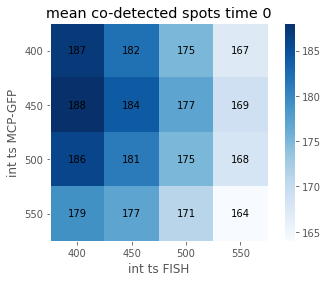

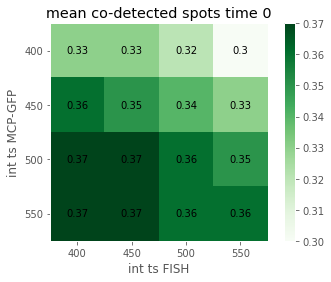

In [15]:
matrix_number_spots_time_0 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
matrix_both_by_total_time_0 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
for k, int_0 in enumerate(list_thresholds_intensity): # rows
    for j, int_1 in enumerate(list_thresholds_intensity): # columns
        df_name_loop = plot_title_suffix+'_time_'+str(0)+ '_int_'+str(int_0)+ '_'+str(int_1)+ '_dist_'+str(ts_distance)
        matrix_both_by_total_time_0[k, j] =   np.round(
                                                np.mean (   
                                                np.nan_to_num(
                                                np.divide( dic_dataframes[df_name_loop]['num_0_1'].values ,  dic_dataframes[df_name_loop]['total'].values)
                                                )
                                                )
                                                ,2)
        matrix_number_spots_time_0[k, j] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_time_0,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_time_0.astype(int)):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title('mean co-detected spots time 0')
fig.colorbar(img)
plt.grid(None)
plt.show()

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_both_by_total_time_0,cmap='Greens')
for (j,i),label in np.ndenumerate(matrix_both_by_total_time_0):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title(r'mean co-detected spots time 0')
fig.colorbar(img)
plt.grid(None)
plt.show()

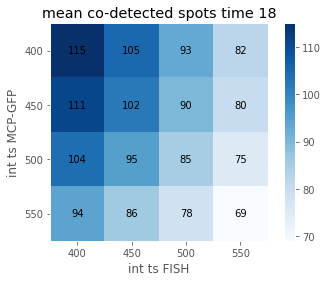

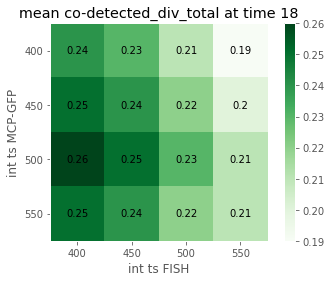

In [10]:
matrix_number_spots_time_18 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
matrix_both_by_total_time_18 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
for k, int_0 in enumerate(list_thresholds_intensity): # rows
    for j, int_1 in enumerate(list_thresholds_intensity): # columns
        df_name_loop = plot_title_suffix+'_time_'+str(18)+ '_int_'+str(int_0)+ '_'+str(int_1)+ '_dist_'+str(ts_distance)
        matrix_both_by_total_time_18[k, j] =   np.round(
                                                np.mean (   
                                                np.nan_to_num(
                                                np.divide( dic_dataframes[df_name_loop]['num_0_1'].values ,  dic_dataframes[df_name_loop]['total'].values)
                                                )
                                                )
                                                ,2)
        matrix_number_spots_time_18[k, j] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_time_18,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_time_18.astype(int)):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title('mean co-detected spots time 18')
fig.colorbar(img)
plt.grid(None)
plt.show()

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_both_by_total_time_18,cmap='Greens')
for (j,i),label in np.ndenumerate(matrix_both_by_total_time_18):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title(r'mean co-detected_div_total at time 18')
fig.colorbar(img)
plt.grid(None)
plt.show()

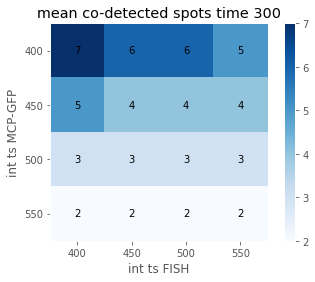

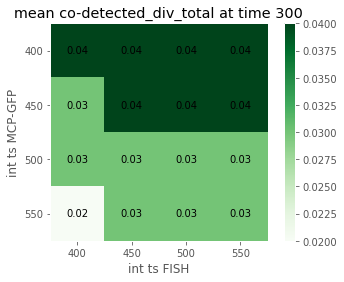

In [11]:
matrix_number_spots_time_300 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
matrix_both_by_total_time_300 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
for k, int_0 in enumerate(list_thresholds_intensity): # rows
    for j, int_1 in enumerate(list_thresholds_intensity): # columns
        df_name_loop = plot_title_suffix+'_time_'+str(300)+ '_int_'+str(int_0)+ '_'+str(int_1)+ '_dist_'+str(ts_distance)
        matrix_both_by_total_time_300[k, j] =   np.round(
                                                np.mean (   
                                                np.nan_to_num(
                                                np.divide( dic_dataframes[df_name_loop]['num_0_1'].values ,  dic_dataframes[df_name_loop]['total'].values)
                                                )
                                                )
                                                ,2)
        matrix_number_spots_time_300[k, j] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_time_300,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_time_300.astype(int)):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title('mean co-detected spots time 300')
fig.colorbar(img)
plt.grid(None)
plt.show()

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_both_by_total_time_300,cmap='Greens')
for (j,i),label in np.ndenumerate(matrix_both_by_total_time_300):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title(r'mean co-detected_div_total at time 300')
fig.colorbar(img)
plt.grid(None)
plt.show()

# Total number of Spots

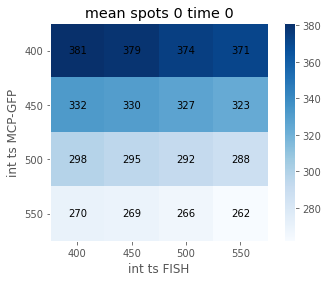

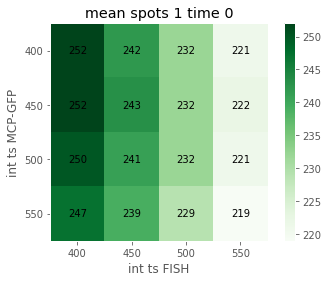

In [17]:
matrix_spots_0_time_0 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
matrix_spots_1_time_0 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_intensity)) )
for k, int_0 in enumerate(list_thresholds_intensity): # rows
    for j, int_1 in enumerate(list_thresholds_intensity): # columns
        # df_name_loop = plot_title_suffix+'_time_'+str(0)+ '_int_'+str(int_0)+ '_'+str(int_1)+ '_dist_'+str(ts_distance)
        # matrix_both_by_total_time_0[k, j] =   np.round(
        #                                         np.mean (   
        #                                         np.nan_to_num(
        #                                         np.divide( dic_dataframes[df_name_loop]['num_0_1'].values ,  dic_dataframes[df_name_loop]['total'].values)
        #                                         )
        #                                         )
        #                                         ,2)
        # matrix_number_spots_time_0[k, j] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)
        df_name_loop = plot_title_suffix+'_time_'+str(0)+ '_int_'+str(int_0)+ '_'+str(int_1)+ '_dist_'+str(ts_distance)
        matrix_spots_0_time_0[k, j] = np.round( dic_dataframes[df_name_loop]['num_0'].values.mean(), 0)
        matrix_spots_1_time_0[k, j] = np.round( dic_dataframes[df_name_loop]['num_1'].values.mean(), 0)

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_spots_0_time_0,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_spots_0_time_0.astype(int)):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title('mean spots 0 time 0')
fig.colorbar(img)
plt.grid(None)
plt.show()

fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_spots_1_time_0,cmap='Greens')
for (j,i),label in np.ndenumerate(matrix_spots_1_time_0.astype(int)):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(list_thresholds_intensity)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('int ts FISH')
ax.set_ylabel('int ts MCP-GFP')
ax.set_title('mean spots 1 time 0')
fig.colorbar(img)
plt.grid(None)
plt.show()